In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.nn import functional as F
from torch.nn import Sequential, Tanh, Parameter
import mlflow as mlflow
%matplotlib inline

In [15]:
torch.backends.mps.is_available()

True

In [16]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [17]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [18]:
len(vocab)

27

In [19]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [20]:
torch.set_default_device("cpu")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)
n_context = 8
train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182455, 8]) torch.Size([182455])
torch.Size([22843, 8]) torch.Size([22843])
torch.Size([22848, 8]) torch.Size([22848])


In [21]:
Xtr

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  1],
        [ 0,  0,  0,  ...,  0,  1, 21],
        ...,
        [ 0,  0,  0,  ...,  9, 18,  9],
        [ 0,  0,  0,  ..., 18,  9, 21],
        [ 0,  0, 19,  ...,  9, 21, 19]])

In [22]:
e_dim = 10
h_dim = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(vocab), e_dim, generator=g) # character embeddings with dimension of e_dim
W1 = torch.randn(n_context*e_dim, h_dim, generator=g) #* (5/3) /((e_dim * n_context)**0.5) # kammit init
b1 = torch.randn(h_dim, generator=g) * 0.01
W2 = torch.randn(h_dim,len(vocab), generator=g) * 0.01
b2 = torch.randn(len(vocab), generator=g) * 0

#Batch Norm pparameters
bgain = torch.ones((1,h_dim))
bbias = torch.zeros((1,h_dim))
bmeanrunning = torch.zeros((1,h_dim))
bstdrunning = torch.ones((1,h_dim))
alpha = 0.999
eps = 1e-5

parameters = [C,W1,b1,W2,b2,bgain,bbias]

In [23]:
lrs = torch.linspace(-3,1,20)
loglrs = 10**lrs

In [24]:
lossi = []
rsloss = []

In [25]:
sum( p.nelement() for p in parameters)

22297

In [26]:
for p in parameters:
    p.requires_grad = True

In [27]:

t = time.time()
batch_size = 32
lrsloss = []
for i in range(200000):
    #forward pass
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtr[ix]]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    bmeani = preh.mean(0,keepdim=True)
    bstdi = preh.std(0,keepdim = True)
    preh = bgain*(preh - bmeani)/ (bstdi + eps) + bbias
    with torch.no_grad():
        bmeanrunning = alpha * bmeanrunning + (1 - alpha)* bmeani
        bstdrunning = alpha * bstdrunning + (1 - alpha) * bstdi
        
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ytr[ix])
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    for p in parameters:
        p.grad = None 
    #backpass
    loss.backward()
    
    #update
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(F"Mins taken: {(t - time.time())/60}")
print(F" Final loss: {loss.item():.4f}")


loss at 0/200000 3.3278
loss at 10000/200000 2.3650
loss at 20000/200000 2.1976
loss at 30000/200000 2.3111
loss at 40000/200000 2.2568
loss at 50000/200000 2.5404
loss at 60000/200000 2.1509
loss at 70000/200000 2.0810
loss at 80000/200000 2.2902
loss at 90000/200000 1.9292
loss at 100000/200000 2.0163
loss at 110000/200000 2.1714
loss at 120000/200000 2.2342
loss at 130000/200000 1.9031
loss at 140000/200000 1.9786
loss at 150000/200000 2.1432
loss at 160000/200000 2.1003
loss at 170000/200000 2.1394
loss at 180000/200000 2.1117
loss at 190000/200000 2.4314
Mins taken: -2.4249257524808248
 Final loss: 2.1135


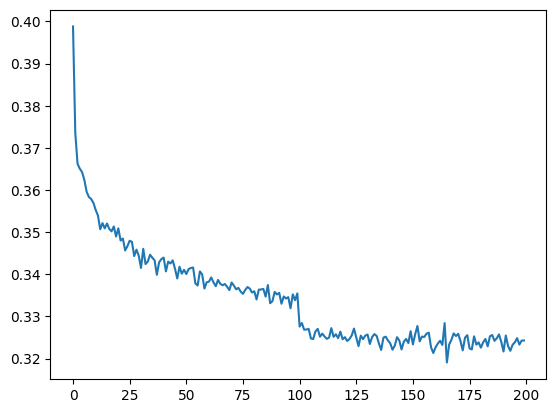

In [28]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

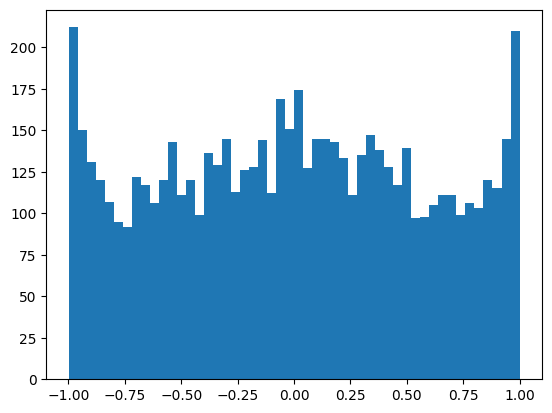

In [29]:
plt.hist(h.view(-1).data,bins=50)
plt.show()

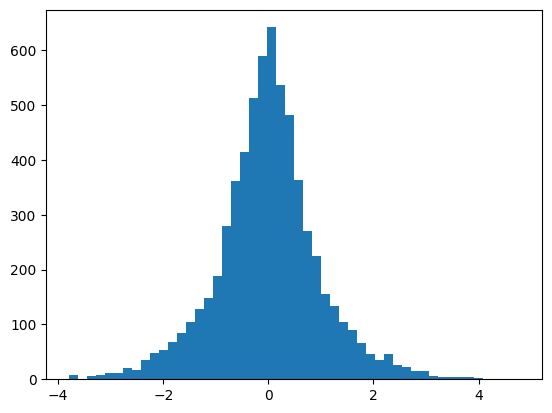

In [30]:
plt.hist(preh.view(-1).data,bins=50)
plt.show()

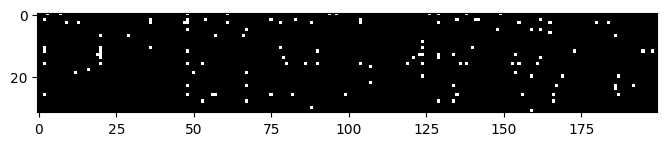

In [31]:
plt.figure(figsize=(8,8))
plt.imshow(h.abs() > .99,cmap="grey",interpolation="nearest");

In [32]:
with torch.no_grad():
    emb = C[Xtr]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    bmean = preh.mean(0,keepdim=True)
    bstd = preh.std(0,keepdim = True)
    

In [33]:
#dev validation
with torch.no_grad():
    # ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xdev]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    preh = bgain*(preh - bmeanrunning)/ bstdrunning + bbias
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ydev)
    print(loss)

tensor(2.1278)


In [34]:
# test validation 
with torch.no_grad():
    # ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtest]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    preh = bgain*(preh - bmeanrunning)/ bstdrunning + bbias
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ytest)
    print(loss)

tensor(2.1101)


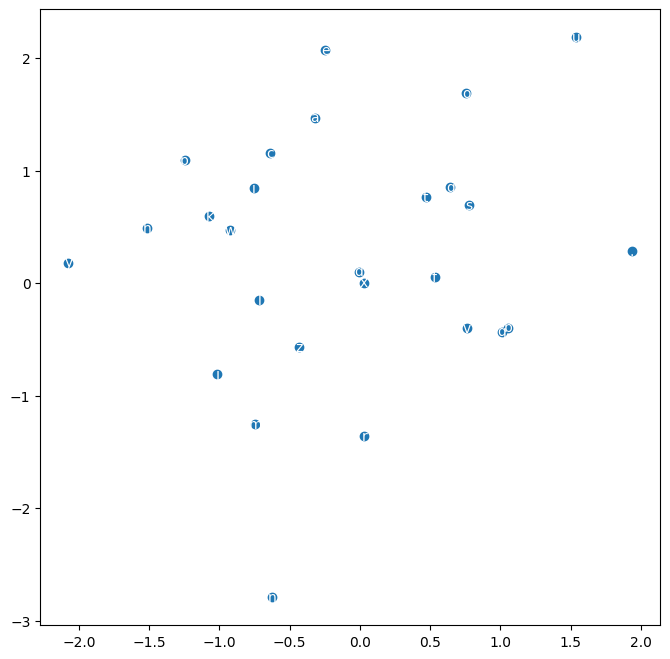

In [35]:
plt.figure(figsize=(8,8))
i=0
C1 = C.cpu().detach().numpy()
plt.scatter(C1[:,0],C1[:,1])
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [36]:


g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    #forward pass
    out = []
    context = [0] * n_context
    while True:
        emb = C[context]
        preh = emb.view(1,-1) @ W1 + b1
        preh = bgain*(preh - bmeanrunning)/ bstdrunning + bbias
        h =  torch.tanh(preh)
        logits= h @ W2 + b2
        p = F.softmax(logits,dim=1)
        ix = torch.multinomial(p,num_samples = 1, replacement = True,generator = g)
        context = context[1:] + [ix.item()]
        if ix.item() == 0:
            break
        out.append(itos[ix.item()])
    print("".join(out))

cexzer
jallus
ilazi
aharion
mittain
lucan
kaida
samiyah
javer
gotai


### Loss log
without any optimization

embedding dimension 2

train loss 1.90

dev loss 2.30

embedding dimension 10

train loss 1.95

dev loss 2.12

kamming init

train loss 2.2

dev loss 2.10


batch norm9

train loss 1.99
dev loss 2.10

In [ ]:
class Linear(torch.nn.Module):
    def __init__(self,nin,nout,bias=True):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.W1 = Parameter(torch.randn(nin, nout))
        self.b1 = Parameter(torch.randn(nout)) if bias else None

    
    def forward(self,x):
        self.out = x @ self.W1 * self.nin**-0.5
        if self.b1 != None:
            self.out = self.out + self.b1
        return self.out
        
class Flatten(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        if len(x.shape) > 2:
            self.out = x.view(x.shape[0],-1)
        else:
            self.out = x.view(-1,x.shape[0]*x.shape[1])
        return self.out
        
class Embedding(torch.nn.Module):
    def __init__(self,vocab_size,edim):
        super().__init__()
        self.embedding = Parameter(torch.randn(vocab_size, edim))

    def forward(self,x):
        self.out = self.embedding[x]
        return self.out

class BatchNorm1d(torch.nn.Module):
    def __init__(self,nout,alpha=0.001,eps=1e-05):
        super().__init__()
        self.nout = nout
        self.bgain = Parameter(torch.ones(1,nout))
        self.bbias = Parameter(torch.zeros(1,nout))
        self.bstdrunning = torch.ones(1,nout)
        self.bmeanrunning = torch.zeros(1,nout)
        self.alpha = alpha
        self.eps = eps
        
    def forward(self,x):
        if(self.training):
            bmeani = x.mean(0,keepdim=True)
            bstdi = x.std(0,keepdim = True)
            self.out = self.bgain*(x - bmeani)/ (bstdi + self.eps) + self.bbias
            with torch.no_grad():
                self.bmeanrunning = self.alpha * self.bmeanrunning + (1 - self.alpha)* bmeani
                self.bstdrunning = self.alpha * bstdrunning + (1 - self.alpha) * bstdi
        else:
            self.out = self.bgain*(x - self.bmeanrunning)/ (self.bstdrunning + self.eps) + self.bbias

        return self.out
    
class Tanh1(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        self.out = F.tanh(x)
        return self.out
    
@torch.no_grad()
def evaluate(X,Y,model):
    model.eval()
    out = model(X)
    loss = F.cross_entropy(out,Y)
    return out,loss

@torch.no_grad()
def generate(n_words,model):
    model.eval()
    for i in range(10):
        #forward pass
        out = []
        context = [0] * n_context
        while True:
            logits= model([context])
            p = F.softmax(logits,dim=1)
            ix = torch.multinomial(p,num_samples = 1, replacement = True,generator = g)
            context = context[1:] + [ix.item()]
            if ix.item() == 0:
                break
            out.append(itos[ix.item()])
        print("".join(out))


In [38]:
Model =  Sequential(
    Embedding(len(vocab),e_dim),
    Flatten(),Linear(n_context*e_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    Linear(h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    Linear(h_dim,h_dim,False),BatchNorm1d(h_dim),Tanh1(),
    Linear(h_dim,len(vocab),False)
)

In [39]:
batch_size = 32
lrsloss = []

for i in range(200000):
    #forward pass
    lr = 0.1 if i <100000 else 0.01
    Model.train()
    # optimizer = torch.optim.SGD(Model.parameters(), lr=lr)
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    out= Model.forward(Xtr[ix])
    loss = F.cross_entropy(out,Ytr[ix])
    # lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    #backpass
    for p in Model.parameters():
        p.grad = None
    loss.backward(retain_graph=True)
    for p in Model.parameters():
        p.data += -lr*p.grad
    

print(F"Mins taken: {(t - time.time())/60}")
print(F" Final loss: {loss.item():.4f}")

loss at 0/200000 3.4514
loss at 10000/200000 2.6784
loss at 20000/200000 2.4457
loss at 30000/200000 2.2516
loss at 40000/200000 2.1329
loss at 50000/200000 1.7274
loss at 60000/200000 1.7846
loss at 70000/200000 2.1583
loss at 80000/200000 1.8272
loss at 90000/200000 2.0806
loss at 100000/200000 2.2159
loss at 110000/200000 2.1722
loss at 120000/200000 2.4045
loss at 130000/200000 2.0492
loss at 140000/200000 1.7555
loss at 150000/200000 2.4836
loss at 160000/200000 1.9377
loss at 170000/200000 2.4876
loss at 180000/200000 2.1197
loss at 190000/200000 2.6818
Mins taken: -8.789285318056743
 Final loss: 2.1602


In [40]:
evaluate(Xdev,Ydev,Model)

(tensor([[-3.3585,  1.9908,  0.6410,  ..., -1.8665, -0.1362,  0.1287],
         [-0.6157,  5.6862, -1.5401,  ..., -3.0682,  1.8682, -1.2732],
         [-2.7360,  0.0895, -0.1963,  ..., -0.5404,  2.2197, -0.2778],
         ...,
         [-0.0327,  3.4106, -1.3364,  ..., -2.0848,  1.7270, -1.2380],
         [ 2.2282,  1.8130,  0.7700,  ..., -2.4327,  0.2649, -0.8610],
         [ 4.8155,  2.8757, -0.7487,  ..., -3.2834,  1.2819, -0.9454]]),
 tensor(2.1814))

In [41]:
generate(10,Model)

moriella
ovie
tedaria
emilyse
sueniavi
ryon
bsimhilin
broahlan
dasdr
banell
